In [1]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage import img_as_uint
#!pip install scikit-image

In [2]:
import os, imghdr
import pickle
from glob import glob

In [3]:
import stretchablecorr as sc

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from scipy.integrate import cumtrapz

# Stretchable Corr - Post-process

## Search and select images

In [6]:
def get_stretch(image_name, sample_name):
    """extract stretch value from filename

    ex: hpr10p100031.TIF --> 0.1%
    """
    image_name = image_name.replace(sample_name, '')
    image_name = image_name.split('.')[0]
    u, d = image_name.split('p')
    d = d[:2]
    s = float(u) + float(d)/100
    return s

Available samples
0 - PDMS_Amazon_18juin
1 - HS2_01
2 - hpr1_01


> Select an image directory: 1


HS2_01 selected
Load images from ./images/HS2_01...
Image sequence:
 24 frames , 1392*1024 pixels , memory size: 261 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  60p000278.TIF
figure saved at output/HS2_01/01_cube_std.svg
 24 stretch values extracted


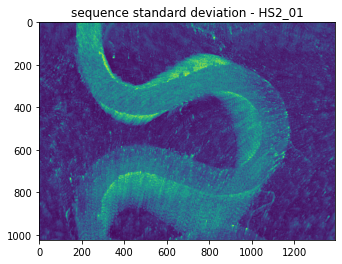

In [11]:
# ==================
#  Load image cube
# ==================
sample_name, sample_input_dir = sc.select_sample_dir('./images')
cube, image_names = sc.load_image_sequence(sample_input_dir)

output_dir = 'output'
resultdir = os.path.join(output_dir, sample_name)

# Graph std
plt.figure(); plt.title(f'sequence standard deviation - {sample_name}');
plt.imshow(np.std(cube, axis=0), cmap='viridis');
sc.save_fig('01_cube_std', sample_name, output_dir=output_dir)

# extract stretch value from filenames
stretch_values = [get_stretch(n, 'hpr1') for n in image_names]
print('\n', f'{len(stretch_values)} stretch values extracted')

## 1. Eulerian displacement

In [13]:
# List available dataset
datasets = glob(os.path.join(resultdir, '*.pck'))

print(f'Available data set for {sample_name}')
print( '=======================' + '='*len(sample_name) )
sc.print_numbered_list([os.path.basename(d) for d in datasets])

# Select a sample:
dataset_id = input('> Select an file:')
data_file = datasets[int(dataset_id)]
print('load', data_file)

# Load dataset
with open(data_file, 'rb') as f:
    grid, displ_Euler, meta = pickle.load(f)

window_half_size = meta['window_half_size']

points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

Available data set for HS2_01
0 - displ_Lagrangian_img_to_img_2990pts.pck
1 - displ_Euler_img_to_img_130pts.pck
2 - displ_Euler_img_to_img.pck
3 - displ_Lagrangian_img_to_img_88pts.pck


> Select an file: 1


load output/HS2_01/displ_Euler_img_to_img_130pts.pck


In [15]:
# graphs 1. Champ de déplacement
for image_id, displ in enumerate(displ_Euler):
    plt.figure();
    plt.imshow(cube[image_id]);
    sc.plot_vector_field(points, displ, view_factor=None)
    plt.title(f'displacement field - {image_id}→{image_id+1} - window:{window_half_size*2+1}px');
    figname = f'disp_field_{image_id:04d}'
    sc.save_fig(figname, sample_name, 'img_to_img', close=True)
    
    
    without_translation = displ - np.nanmean(displ, axis=0)
    plt.figure();
    plt.imshow(cube[image_id]);
    sc.plot_vector_field(points, without_translation, view_factor=None)
    plt.title(f'displ. field (w/o translation) - {image_id}→{image_id+1} - window:{window_half_size*2+1}px');
    figname = f'disp_field_woTr_{image_id:04d}'
    sc.save_fig(figname, sample_name, 'img_to_img', close=True)
    
print('done', ' '*40)

done                                         sp_field_woTr_0022.svg


In [17]:
print('Do bilinear fits')
all_coeffs = []
all_residuals = []
for displ_field in displ_Euler:
    coeffs, residuals = sc.bilinear_fit(points, displ_field)
    all_coeffs.append(coeffs)
    all_residuals.append(residuals)

linear_def_from_previous = np.stack(all_coeffs, axis=0)
residuals_from_previous = np.stack(all_residuals, axis=0)

Do bilinear fits


u = M*x + t

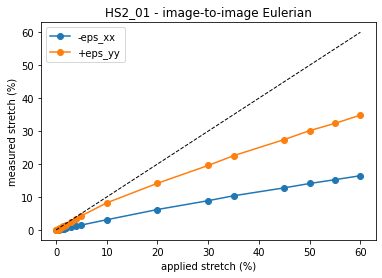

In [19]:
eps_xx_img2img = [M[0, 0] for M in all_coeffs]
eps_yy_img2img = [M[1, 1] for M in all_coeffs]

def cumsumzero(a, **kargs):
    return np.cumsum(np.pad(a, (1, 0), "constant"), *kargs)

eps_xx = cumsumzero(eps_xx_img2img)*100
eps_yy = cumsumzero(eps_yy_img2img)*100

plt.plot(stretch_values, -eps_xx, 'o-', label='-eps_xx');
plt.plot(stretch_values, eps_yy, 'o-', label='+eps_yy');
plt.plot(stretch_values, stretch_values, '--', color='black', linewidth=1)
plt.xlabel('applied stretch (%)');
plt.ylabel('measured stretch (%)');
plt.legend(); plt.title(sample_name + ' - image-to-image Eulerian');
sc.save_fig('measured_vs_applied_stretch_Eulerian', sample_name);

## 2. Lagrangian displacement

In [21]:
# List available dataset
datasets = glob(os.path.join(resultdir, '*.pck'))

print(f'Available data set for {sample_name}')
print( '=======================' + '='*len(sample_name) )
sc.print_numbered_list([os.path.basename(d) for d in datasets])

# Select a sample:
dataset_id = input('> Select an file:')
data_file = datasets[int(dataset_id)]
print(data_file)

# Load dataset
with open(data_file, 'rb') as f:
    grid, displ_Lagrangian, meta = pickle.load(f)

window_half_size = meta['window_half_size']
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

print('')
print(f'{len(displ_Lagrangian)}')
print(f'{len(cube)}')

Available data set for HS2_01
0 - displ_Lagrangian_img_to_img_2990pts.pck
1 - displ_Euler_img_to_img_130pts.pck
2 - displ_Euler_img_to_img.pck
3 - displ_Lagrangian_img_to_img_88pts.pck


> Select an file: 3


output/HS2_01/displ_Lagrangian_img_to_img_88pts.pck

23
24


In [22]:
# Integrate
# image-to-image fields to get image-to-ref displ.

# add zeros at the begining
zeros = np.zeros_like(displ_Lagrangian[0])[np.newaxis, :, :]
displ_Lagrangian_zero = np.concatenate([zeros, displ_Lagrangian], axis=0)

displ_lagrangian_to_ref = np.cumsum(displ_Lagrangian_zero, axis=0)
print(f'{len(displ_lagrangian_to_ref)}')
positions = displ_lagrangian_to_ref + points

# keep only enterely visible path
mask = ~np.any(np.isnan(displ_Lagrangian), axis=(0, 2))

24


### Deformed mesh

In [23]:
def plot_deformed_mesh(grid, displ_field,
                       color_values=None,
                       view_factor=10, cmap='Spectral'):
    
    if color_values is None:
        color_values = np.zeros_like(grid[0])
    
    # Scale displacements using view_factor
    points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )
    positions_amplified = displ_field*view_factor + points
    x_amplified = positions_amplified[:, 0].reshape(grid[0].shape)
    y_amplified = positions_amplified[:, 1].reshape(grid[0].shape)

    # Background Reference grid:
    moved_out = np.any(np.isnan(displ_field), axis=1).reshape(grid[0].shape)
    ref_colors = np.zeros_like(moved_out)
    ref_colors[moved_out] = 1
    
    plt.pcolor(*grid, ref_colors,
               edgecolors='black', linewidth=1, antialiased=True,
               cmap='Reds', alpha=0.1);

    # Front mesh:
    plt.pcolor(x_amplified, y_amplified, color_values,
               edgecolors='black',
               linewidth=1,
               antialiased=True,
               cmap=cmap);# Spectral
    #plt.clim(0, +10)

    #sigma = np.nanstd(eps_33_pct)
    #m = np.nanmean(eps_33_pct)
    #plt.clim(m-1.5*sigma, m+1.5*sigma)

    plt.axis('equal');
    plt.colorbar();
    plt.xlabel('x [pixel]'); plt.ylabel('y [pixel]');    


def finite_diff_strain(grid, displ_field, nu=0.33):
    # not exactly...
    # see Bower page 72
    x, y = grid

    dx = np.diff(x, axis=1, append=np.NaN)
    dy = np.diff(y, axis=0, append=np.NaN)

    u = displ_field[:, 0].reshape(grid[0].shape)
    v = displ_field[:, 1].reshape(grid[0].shape)
    dudx = np.diff(u, axis=0, append=np.NaN) / dx
    dvdy = np.diff(v, axis=0, append=np.NaN) / dy 

    # Poisson coeff
    eps_33 = (dudx + dvdy)*nu/(1-2*nu)/(1+nu)
    
    return dudx*100, dvdy*100, eps_33*100

In [24]:
use_mask = False

# Load a mask
if use_mask:
    serpentine_mask = io.imread(f'images/{sample_name}_mask.png')
    serpentine_mask = serpentine_mask[:, :, -1] < 150

    points_mask = serpentine_mask[points[:, 1], points[:, 0]]
    points_mask = points_mask.reshape(grid[0].shape)

    #points_mask = np.logical_not( points_mask )
    #print(points_mask[0, 0])
else:
    points_mask = np.ones_like(points[:, 0])

In [27]:
view_factor = 3
Poisson_coeff = 0.3
eps_zz_limits = -5, 15 

for image_id, displ_field in enumerate(displ_lagrangian_to_ref):

    eps_xx, eps_yy, eps_zz = finite_diff_strain(grid, displ_field, nu=Poisson_coeff)
    field_value = eps_yy
    field_value_name = 'eps_yy'
    
    if points_mask is not None:
        field_value[points_mask] = np.NaN
    
    plt.figure(figsize=(15, 8));
    plot_deformed_mesh(grid, displ_field,
                       color_values=field_value,
                       view_factor=view_factor,
                       cmap='jet') #Spectral

    plt.clim(*eps_zz_limits)
    title =  f'{sample_name} - {stretch_values[image_id]}% - '
    title += f'{image_names[image_id]} - '
    #title += f'eps_zz [%] (nu={Poisson_coeff}) - '
    title += f'{field_value_name} [%] - '
    title += f'displ. scale x{view_factor}'
    plt.title(title);
    
    output_dir = f'{field_value_name}_maps' if points_mask is None else f'{field_value_name}_maps_mask'
    sc.save_fig(f'{field_value_name}_{image_id:03d}',
                sample_name,
                output_dir, close=True)
    
print('\n done')

figure saved at ./output/HS2_01/eps_yy_maps_mask/eps_yy_023.svg           
 done


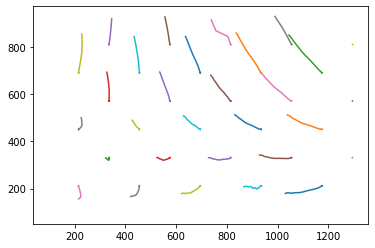

In [28]:
traj = displ_lagrangian_to_ref + points

for k in range(0, len(points), 2):
    plt.plot(*traj[:, k, :].T)

### Measured strain vs Applied strain

Do bilinear fits
23 24
8 24


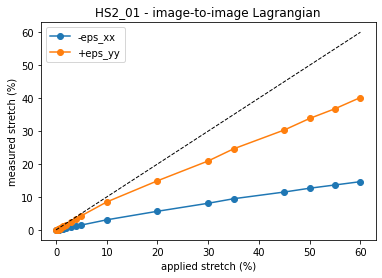

In [30]:
print('Do bilinear fits')
all_coeffs = []
all_residuals = []
for displ_field in displ_Lagrangian:
    coeffs, residuals = sc.bilinear_fit(points, displ_field)
    all_coeffs.append(coeffs)
    all_residuals.append(residuals)

linear_def_from_previous = np.stack(all_coeffs, axis=0)
residuals_from_previous = np.stack(all_residuals, axis=0)


eps_xx_img2img = [M[0, 0] for M in all_coeffs]
eps_yy_img2img = [M[1, 1] for M in all_coeffs]

def cumsumzero(a, **kargs):
    return np.cumsum(np.pad(a, (1, 0), "constant"), *kargs)

print(len(eps_xx_img2img), len(stretch_values))
print(len(eps_yy), len(stretch_values))

eps_xx = cumsumzero(eps_xx_img2img)*100
eps_yy = cumsumzero(eps_yy_img2img)*100

plt.plot(stretch_values[:len(eps_xx)], -eps_xx, 'o-', label='-eps_xx');
plt.plot(stretch_values[:len(eps_xx)], eps_yy, 'o-', label='+eps_yy');
plt.plot(stretch_values[:len(eps_xx)], stretch_values[:len(eps_xx)], '--', color='black', linewidth=1)
plt.xlabel('applied stretch (%)');
plt.ylabel('measured stretch (%)');
plt.legend(); plt.title(sample_name + ' - image-to-image Lagrangian');
sc.save_fig('measured_vs_applied_stretch_Lagrangian', sample_name);

### Profiles

In [31]:
def plot_Y_profile(nearest_x, image_id,
                   grid,
                   displ_lagrangian_to_ref,
                   color = 'darkorange'):
    
    dx = displ_lagrangian_to_ref[image_id, :, 0].reshape(grid[0].shape)
    dy = displ_lagrangian_to_ref[image_id, :, 1].reshape(grid[0].shape)

    # Profils Y
    x_span = grid[0][0, :]
    j = np.searchsorted(x_span, nearest_x)
    
    dy_profile = dy[:, j]
    mask_dy_profile = ~np.isnan(dy_profile)
    dy_profile = dy_profile[mask_dy_profile]

    y_profile = grid[1][:, j][mask_dy_profile]
    x_profile = grid[0][:, j][mask_dy_profile]
    
    plt.plot(y_profile,
             dy_profile,
             color=color,
             label=f'at x={x_span[j]} px')
    
    plt.xlabel('y [px]'); plt.ylabel('displ. v [px]');
    plt.title(f"displ. component v - image {image_names[image_id].split('.')[0]}")

    a, b = np.polyfit(y_profile, dy_profile, 1)
    plt.plot(y_profile, a*y_profile + b, ':',
             color=color, alpha=0.8,
             label=f'$\epsilon_y$=dv/dy={a*100:.2f}%');
    plt.legend();
    return x_profile, y_profile, dy_profile

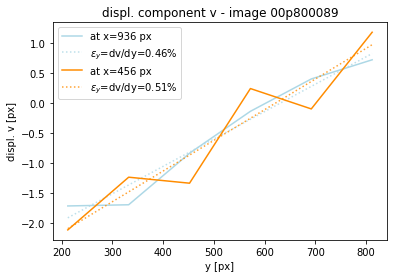

In [32]:
image_id = 8

x1050, y1050, v1050 = plot_Y_profile(850, image_id,
               grid,
               displ_lagrangian_to_ref,
               color = 'lightblue')

x450, y450, v450 = plot_Y_profile(450, image_id,
               grid,
               displ_lagrangian_to_ref,
               color = 'darkorange')

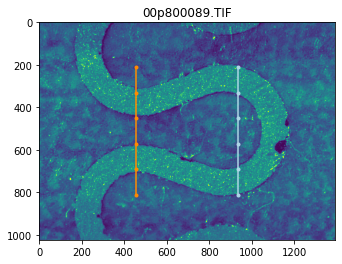

In [33]:
plt.figure();
plt.imshow(cube[image_id, :, :]);
plt.plot(x450, y450, '.-', color='darkorange')
plt.plot(x1050, y1050, '.-', color='lightblue')
plt.title(f'{image_names[image_id]}');